In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
from transformers import CLIPModel
from transformers import CLIPProcessor
import time
import faiss


In [2]:
#used: https://www.geeksforgeeks.org/how-to-manipulate-the-pixel-values-of-an-image-using-python/

In [3]:
filename = "./myntradataset/styles.csv"
df = pd.read_csv(filename, on_bad_lines="skip") #some lines of the dataset fail due to excess commas

available_ids = os.listdir("./myntradataset/images")
available_ids2 = [int(x.replace(".jpg","")) for x in available_ids]
df = df[df.id.isin(available_ids2)] #some images are not actually available


df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [4]:
def display_images_and_titles(filepaths, titles):
    # Create a 4x5 grid of subplots
    fig, axes = plt.subplots(4, 5, figsize=(12, 10))

    # Loop through the filepaths and display images in the subplots
    for i, ax in enumerate(axes.flatten()):
        if i < len(filepaths):
            filepath = filepaths[i]
            image = plt.imread(filepath)
            ax.imshow(image)
            ax.axis('off')

            # Assign a title to each subplot
            ax.set_title(f"{titles[i]}", fontsize = 7)
        else:
            ax.axis('off')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

def display_images_titles_from_ids(ids, directory):
    df_new_index = df.copy()
    df_new_index['id'] = df_new_index['id'].astype(str)
    df_new_index.set_index("id",inplace = True)
    df_new_index = df_new_index.loc[ids]
    filenames = df_new_index.index.tolist()
    filepaths = [f"{os.path.join(directory,filename)}.jpg"  for filename in filenames]
    titles =  df_new_index.productDisplayName.tolist()
    
    display_images_and_titles(filepaths, titles)

    


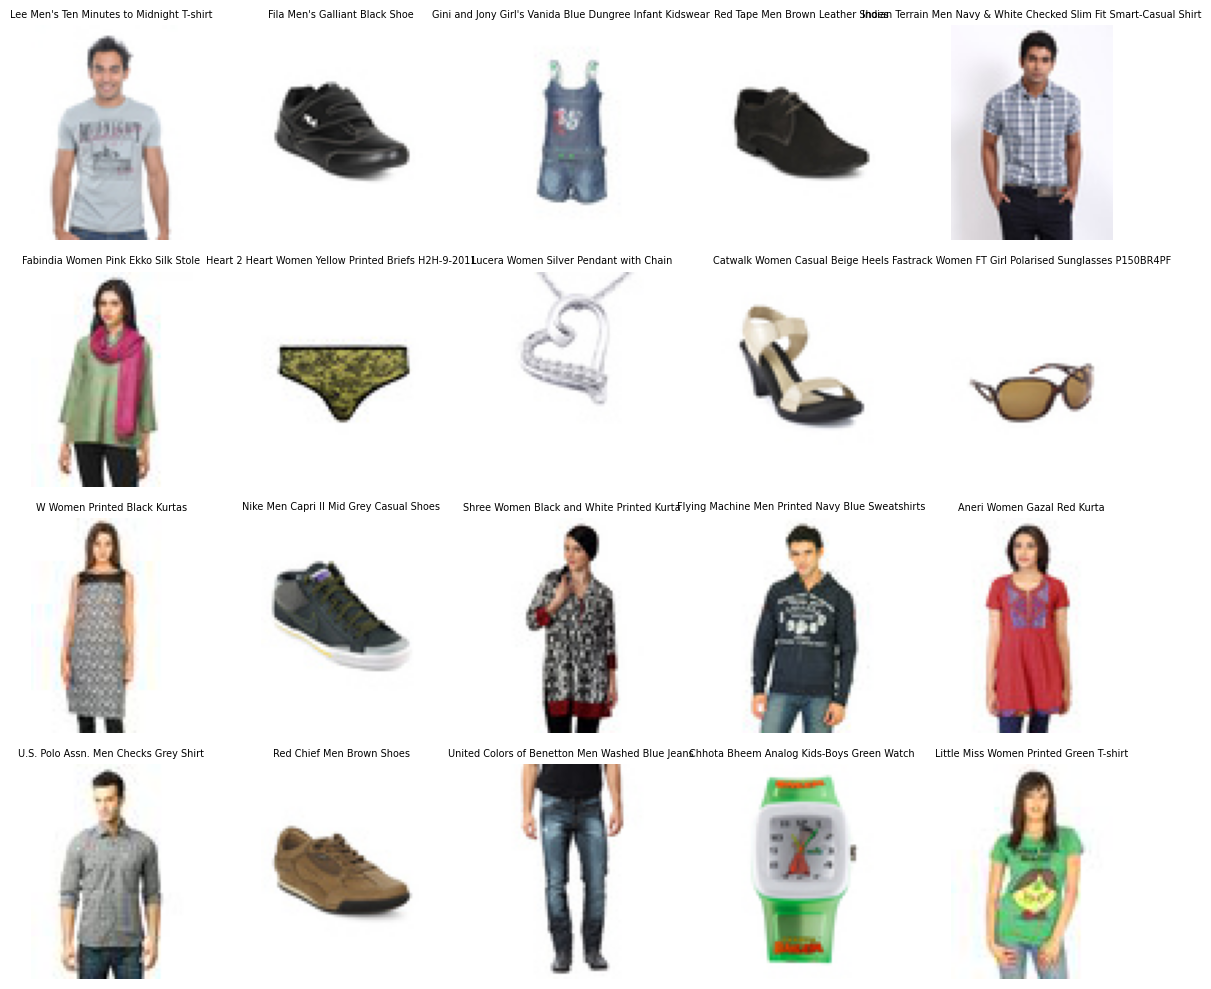

In [5]:
# You'll need to change this
directory = "/Users/meagankenney/IMA Bootcamp/Ebay/myntradataset/images/"

# Display 20 random images
random_subset = df.iloc[np.random.randint(0,df.shape[0], size = 20)]
filenames = random_subset.id.astype(str).tolist()
filepaths = [f"{os.path.join(directory,filename)}.jpg"  for filename in filenames]
titles = random_subset.productDisplayName.tolist()

display_images_and_titles(filepaths, titles)

In [6]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [7]:
#My test image
local_pic = "./myntradataset/test_images/testpic2.jpeg" 
#Open the image
image = Image.open(local_pic)
#What text do you want to attach
text=["red bag"]
#Gather inputs: text, image, etc.
inputs = processor(text=text, images=image, return_tensors="pt", padding=True)
#Get outputs
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
#Get embeddings
#print("image embedding(s) shape:", outputs.image_embeds.shape)
#print("text embedding(s) shape:", outputs.text_embeds.shape)

In [8]:
knn_vectors = torch.load("image_tensor.pt")
knn_labels = df.id.astype(str).tolist()

In [9]:
# Convert data to numpy arrays for use with faiss
vectors_np = knn_vectors.numpy()

# Build the index
dimension = vectors_np.shape[1]  # Dimension of the vectors
index = faiss.IndexFlatL2(dimension)
index.add(vectors_np)

In [10]:
index = faiss.IndexFlatL2(dimension)
index.add(vectors_np)

In [11]:
np_TP = outputs.image_embeds.detach().cpu().numpy() #Turn the outputs into np array instead of Tensor Torch

# Select a query vector ADD input the test picture np array that you want to query similar images of
query_vector = np_TP.reshape(1, -1) 

# Query the index
k = 20  # Number of neighbors to return
D, I = index.search(query_vector, k)

# `I` now contains the indices of the 10 nearest neighbors to the first vector
# `D` contains the corresponding squared L2 distances

# Get labels of the neighbors
neighbor_labels = [knn_labels[i] for i in I[0]]

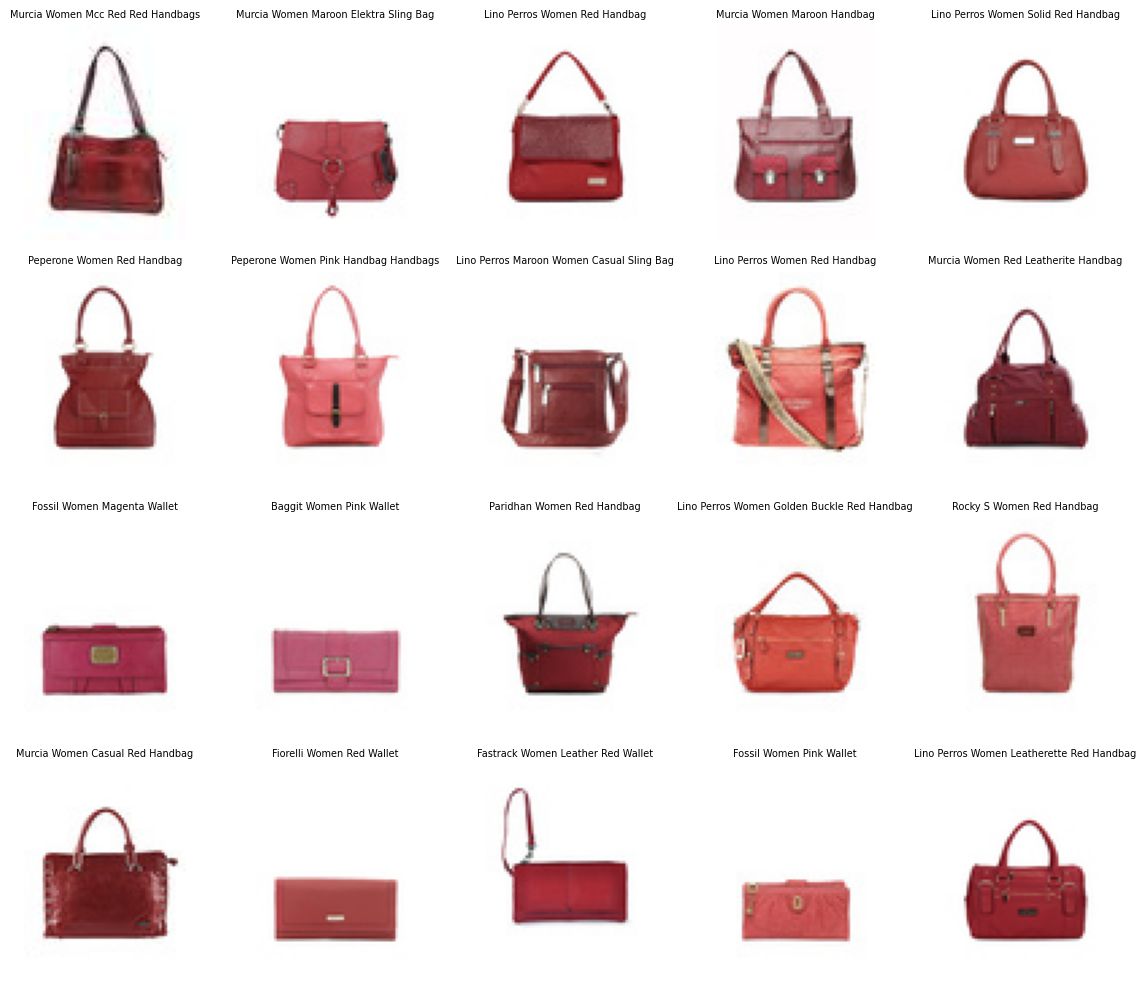

In [12]:
directory = "/Users/meagankenney/IMA Bootcamp/Ebay/myntradataset/images/"
display_images_titles_from_ids(neighbor_labels, directory)

In [13]:
local_pic = "./myntradataset/test_images/testpic2.jpeg"
custom_image = Image.open(local_pic)
px = custom_image.load()

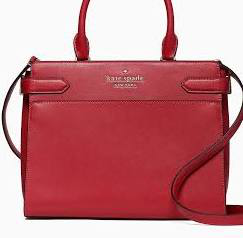

In [14]:
custom_image

In [15]:
def red2green(image):
    input_image = Image.open(image)

    # Extracting pixel map:
    pixel_map = input_image.load()

    # Extracting the width and height 
    # of the image:
    width, height = input_image.size
    for i in range(width):
        for j in range(height):

            # getting the current RGB value of pixel (i,j).
            curr = input_image.getpixel((i, j))
            #Only targeting the pixels that have red
            if curr[0] <=240:
                        # Assign new color switching the reds and greens
                        new = (curr[1], curr[0], curr[2])
                        # setting the pixel value.
                        pixel_map[i, j] = new

    # Saving the final output
    # as "redtogreen.png":
    input_image.save("./myntradataset/test_images/redtogreen", format="png")
    return input_image

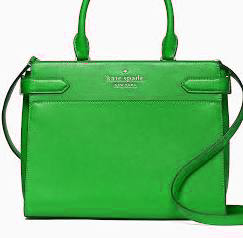

In [16]:
red2green(local_pic)

In [17]:
def red2greenrun():
    #My test image
    local_pic = "./myntradataset/test_images/redtogreen"
    #Open the image
    image = Image.open(local_pic)
    #What text do you want to attach
    #text=["red bag"]
    #Gather inputs: text, image, etc.
    inputs = processor(text=text, images=image, return_tensors="pt", padding=True)
    #Collect outputs
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    
    #Get embeddings
    knn_vectors = torch.load("image_tensor.pt")
    knn_labels = df.id.astype(str).tolist()
    index = faiss.IndexFlatL2(dimension)
    index.add(vectors_np)
    
    #Turn the outputs into np array instead of Tensor Torch
    np_TP = outputs.image_embeds.detach().cpu().numpy() 
    
    # Select a query vector ADD input the test picture np array that you want to query similar images of
    query_vector = np_TP.reshape(1, -1) 
    
    # Query the index
    k = 20  # Number of neighbors to return
    D, I = index.search(query_vector, k)
    
    # `I` now contains the indices of the 10 nearest neighbors to the first vector
    # `D` contains the corresponding squared L2 distances
    # Get labels of the neighbors
    neighbor_labels = [knn_labels[i] for i in I[0]]
    directory = "/Users/meagankenney/IMA Bootcamp/Ebay/myntradataset/images/"
    display_images_titles_from_ids(neighbor_labels, directory)

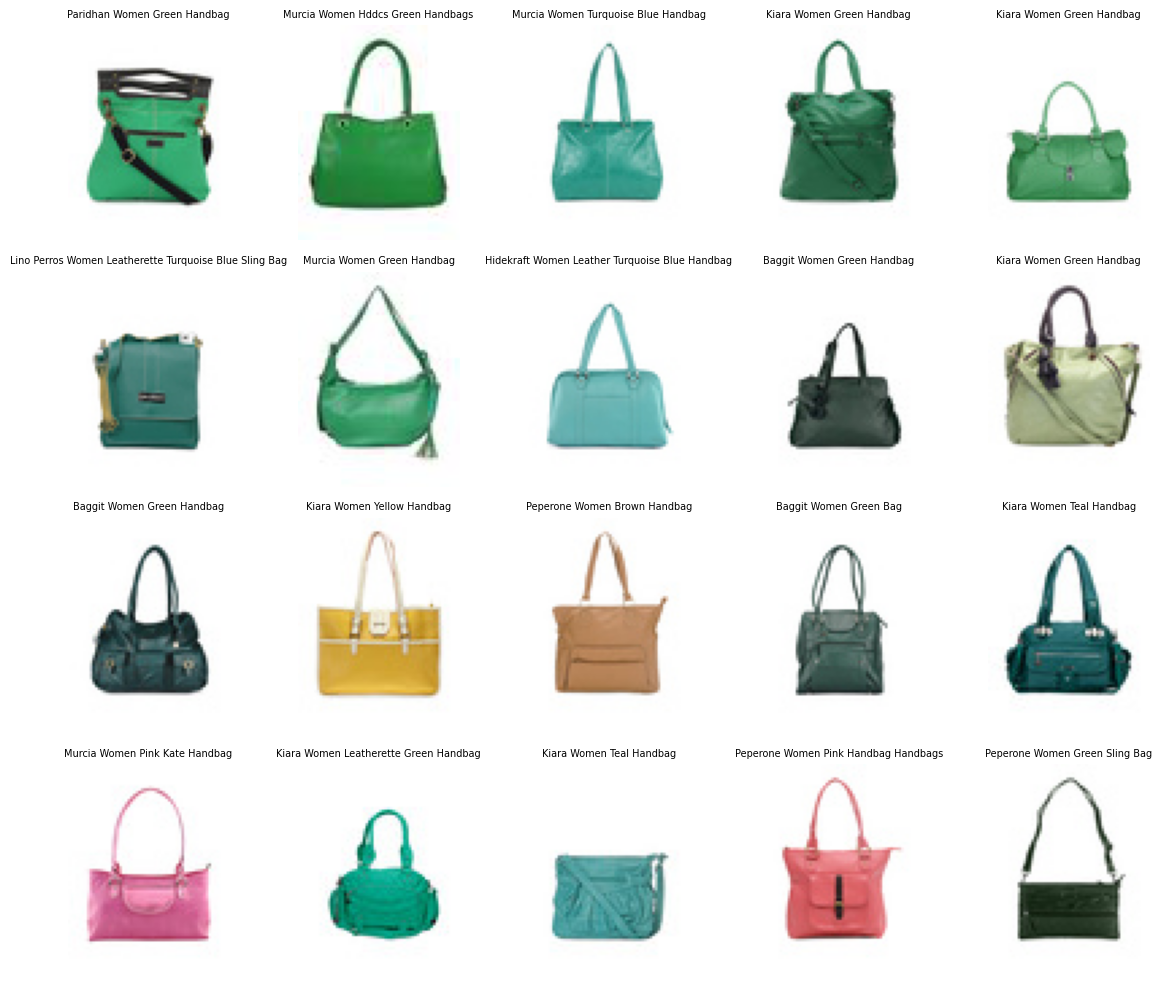

In [18]:
red2greenrun()

In [19]:
def red2blue(image):
    input_image = Image.open(image)

    # Extracting pixel map:
    pixel_map = input_image.load()

    # Extracting the width and height 
    # of the image:
    width, height = input_image.size
    for i in range(width):
        for j in range(height):

            # getting the current RGB value of pixel (i,j).
            curr = input_image.getpixel((i, j))
            #Only targeting the pixels that have red
            if curr[0] <=240:
                        # Assign new color switching the reds and blues
                        new = (curr[2], curr[1], curr[0])
                        # setting the pixel value.
                        pixel_map[i, j] = new

    # Saving the final output
    # as "redtoblue.png":
    input_image.save("./myntradataset/test_images/redtoblue", format="png")
    return input_image

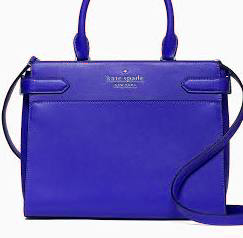

In [20]:
red2blue("./myntradataset/test_images/testpic2.jpeg")

In [21]:
def red2bluerun():
    #My test image
    local_pic = "./myntradataset/test_images/redtoblue"
    #Open the image
    image = Image.open(local_pic)
    #What text do you want to attach
    #text=["red bag"]
    #Gather inputs: text, image, etc.
    inputs = processor(text=text, images=image, return_tensors="pt", padding=True)
    
    #Collect outputs
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    
    #Get embeddings
    knn_vectors = torch.load("image_tensor.pt")
    knn_labels = df.id.astype(str).tolist()
    index = faiss.IndexFlatL2(dimension)
    index.add(vectors_np)
    
    #Turn the outputs into np array instead of Tensor Torch
    np_TP = outputs.image_embeds.detach().cpu().numpy() 
    
    # Select a query vector ADD input the test picture np array that you want to query similar images of
    query_vector = np_TP.reshape(1, -1) 
    
    # Query the index
    k = 20  # Number of neighbors to return
    D, I = index.search(query_vector, k)
    # `I` now contains the indices of the 10 nearest neighbors to the first vector
    # `D` contains the corresponding squared L2 distances
    # Get labels of the neighbors
    neighbor_labels = [knn_labels[i] for i in I[0]]
    directory = "/Users/meagankenney/IMA Bootcamp/Ebay/myntradataset/images/"
    display_images_titles_from_ids(neighbor_labels, directory)

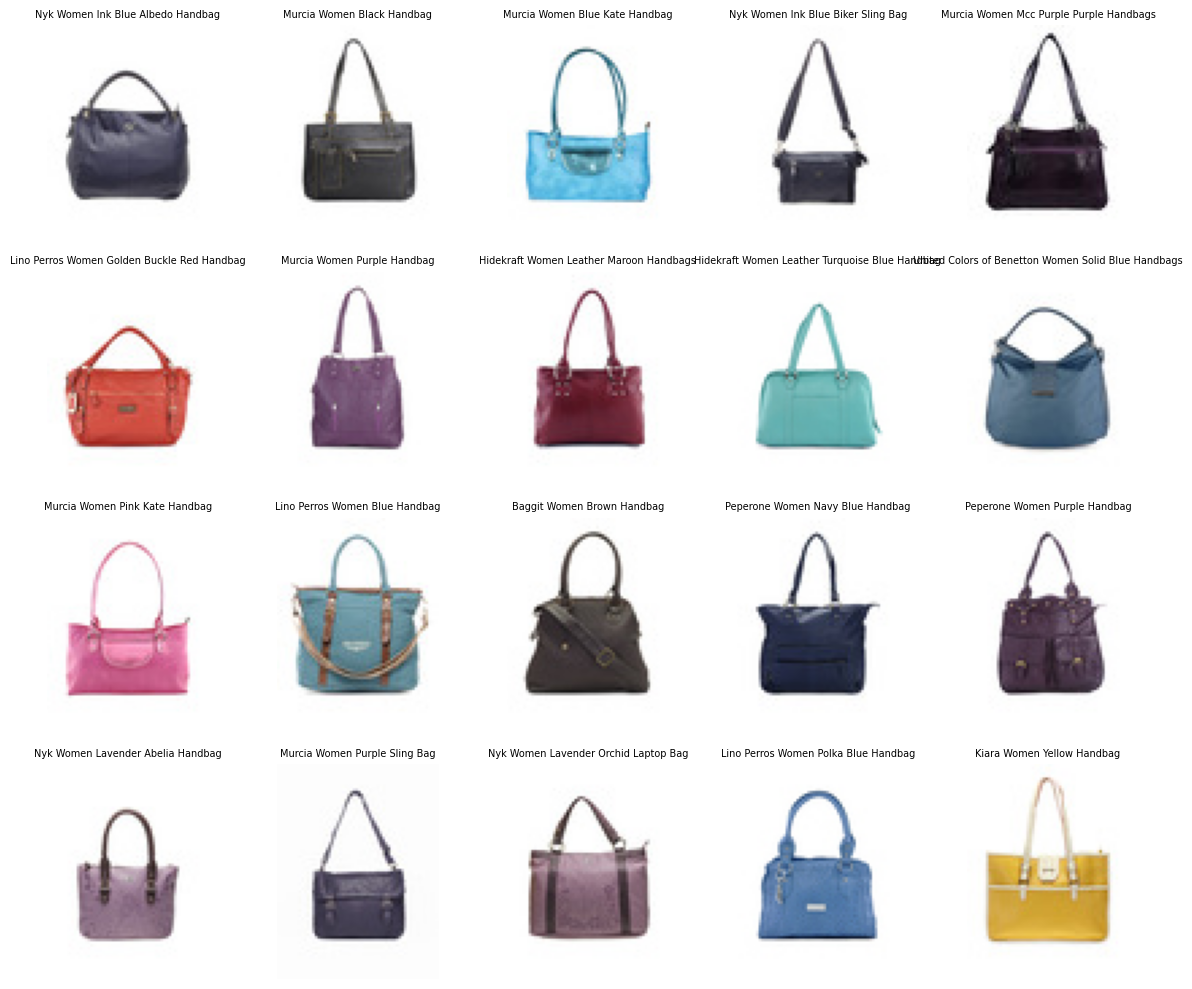

In [44]:
red2bluerun()